# Practice 2. Application of Data Engineering for Exploratory Data Analytics + Machine Learning


## Instructions

Deadline 30/04/2025 EOD (End-Of-Day).

Name your notebook as ADHPC.2025.Practice2-*Name*-*Surname*. Your notebook should be *private* and be shared with the user *gltaboada* (search for Guillermo Lopez Taboada) by the deadline date. Try to save the notebook with *Commit, Save & Run All* option.

Six exercises, 10%-15%-15%-20%-20%-20% of the mark from exercise 1 to 6, respectively:

1. Show with a table (or ideally with a graph):
* a) TOP10 destination airports with the highest number of flights in April 2019
* b) TOP10 origin airports with the highest number of flights in April 2019


2. Using 2019 data plot the takeoff delay based on the time of day (consider local time, not UTC). Take inspiration from the example of avggain vs dist. You have to group the data by the variable(s) that give(s) you the most information. It can be by Carrier, by airport, by medium distance "bucket", etc ... Do another data plot replicating the same with the takeoff delay depending on the time of day. It could be, for example, the mean delay on the "y" axis, the time of day on the "x" axis -time of day in the range 0 - 23, with time 0 being flights between 00:00 and 00:59, and so on-, and finally, with the data grouped by Carrier.


3. Get a report on the percentage and number of flights that are delayed (ARR_DELAY > 14) based on the month, day of the month, day of the week and time of day (4 plots). For 2019 only. Show it with bar charts. 

[SPARKLYR](https://ugoproto.github.io/ugo_r_doc/pdf/sparklyr.pdf)


4. Using 2019 data develop a predictive model of the GAIN variable using the linear regression method. The model developed must be better than the one obtained in this notebook (GAIN ~ DEP_DELAY). Briefly justify the goodness / power of the model developed. You are expected to introduce characteristics to see if they fit the data better, for example the time or the day of the week. Some tests can be documented in text, explaining what is done and others you can present it with a graph. Also, if someone wants, in addition to linear regression, to explore another model, they could, although here I will fundamentally value that you use a linear regression.

5. Using 2019 data generate a model using Naive Bayes that allows us to predict the probability of a flight delay. We want to know the 10 origins with the highest and lowest probability of being delayed, as well as the 10 destinations with the highest and lowest probability of being delayed. 
Original model: DELAYED~ hour + wday

6. Write a short report **(approx. 500 words)** on the performance (execution time based on the number of records and variables being used) of the exercises 4 and 5, and if you are able to improve it.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
sns.set_style('whitegrid')

## Data Loading and Preprocessing

In [2]:

flight_data = pd.read_csv(
    'dataset/2019.csv',
    parse_dates=['FL_DATE'],      
    dtype={
        'DEP_TIME': 'float',     
        'DEP_DELAY': 'float',
        'DISTANCE': 'float'
    }
)

# Date
flight_data['YEAR']  = flight_data['FL_DATE'].dt.year
flight_data['MONTH'] = flight_data['FL_DATE'].dt.month
flight_data['DAY']   = flight_data['FL_DATE'].dt.day

#  departure hour 
# Replace NaN with 0, convert to int, then integer-divide by 100
flight_data['DEP_TIME'] = flight_data['DEP_TIME'].fillna(0).astype(int)
flight_data['DEP_HOUR'] = flight_data['DEP_TIME'] // 100

flight_data.head()

,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,...,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 20,YEAR,MONTH,DAY,DEP_HOUR
0,2019-01-01,9E,3280,GNV,ATL,601,1.0,22.0,623.0,714.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2019,1,1,6
1,2019-01-01,9E,3281,MSP,CVG,1359,-5.0,15.0,1414.0,1629.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2019,1,1,13
2,2019-01-01,9E,3282,DTW,CVG,1215,-5.0,18.0,1233.0,1323.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2019,1,1,12
3,2019-01-01,9E,3283,TLH,ATL,1521,-6.0,14.0,1535.0,1618.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2019,1,1,15
4,2019-01-01,9E,3284,ATL,FSM,1847,-15.0,18.0,1905.0,1935.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2019,1,1,18


## Exercise 1


- 1.a) Top 10 origin airports with the highest number of flights in April 2019
- 1.b) Top 10 destination airports with the highest number of flights in April 2019

  Airport  Flights
0     ATL    32940
1     ORD    27172
2     DFW    23933
3     CLT    19508
4     DEN    19420
5     LAX    17782
6     PHX    15106
7     IAH    14856
8     LGA    14457
9     SFO    13840


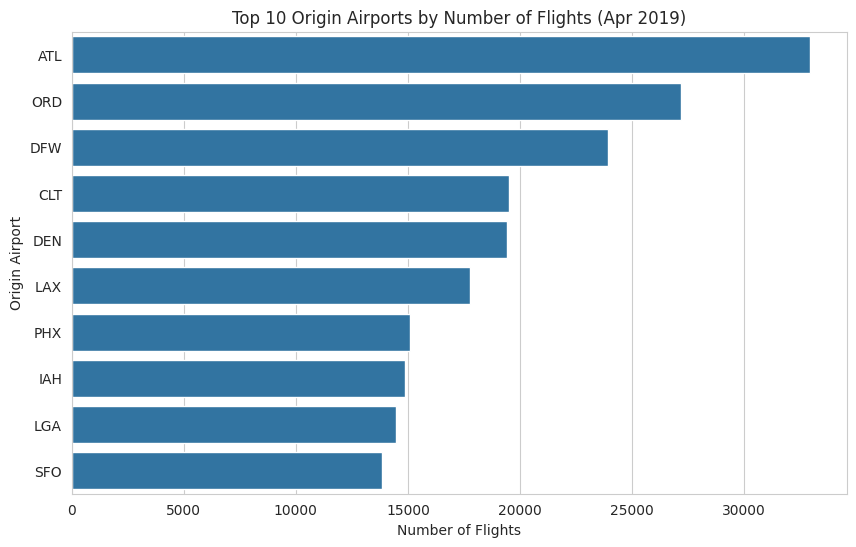

  Airport  Flights
0     ATL    32941
1     ORD    27171
2     DFW    23930
3     CLT    19511
4     DEN    19439
5     LAX    17781
6     PHX    15097
7     IAH    14861
8     LGA    14458
9     SFO    13843


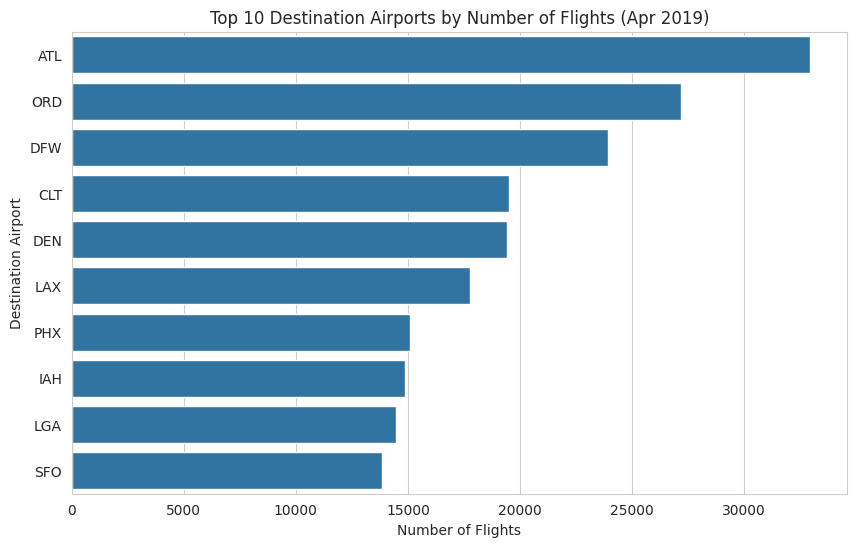

In [3]:
# Filter for April 2019
df_apr2019 = flight_data[(flight_data['YEAR']==2019)&(flight_data['MONTH']==4)]

# 1.a Origin airports
origin_counts = df_apr2019['ORIGIN'].value_counts().nlargest(10).reset_index()
origin_counts.columns = ['Airport', 'Flights']
print(origin_counts)

plt.figure(figsize=(10,6))
sns.barplot(data=origin_counts, x='Flights', y='Airport')
plt.title('Top 10 Origin Airports by Number of Flights (Apr 2019)')
plt.xlabel('Number of Flights')
plt.ylabel('Origin Airport')
plt.show()

# 1.b Destination airports
dest_counts = df_apr2019['DEST'].value_counts().nlargest(10).reset_index()
dest_counts.columns = ['Airport', 'Flights']
print(dest_counts)

plt.figure(figsize=(10,6))
sns.barplot(data=dest_counts, x='Flights', y='Airport')
plt.title('Top 10 Destination Airports by Number of Flights (Apr 2019)')
plt.xlabel('Number of Flights')
plt.ylabel('Destination Airport')
plt.show()

## Exercise 2

Using 2019 data plot the takeoff delay based on the time of day (consider local time, not UTC). Take inspiration from the example of avggain vs dist. You have to group the data by the variable(s) that give(s) you the most information. It can be by Carrier, by airport, by medium distance "bucket", etc ... Do another data plot replicating the same with the takeoff delay depending on the time of day. It could be, for example, the mean delay on the "y" axis, the time of day on the "x" axis -time of day in the range 0 - 23, with time 0 being flights between 00:00 and 00:59, and so on-, and finally, with the data grouped by Carrier.

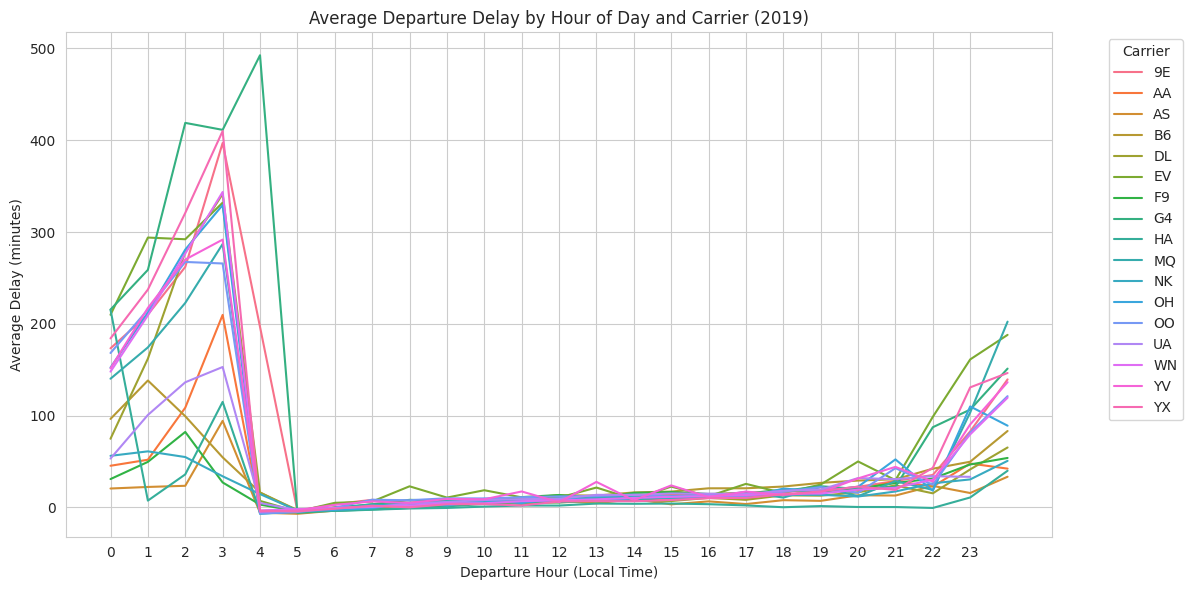

In [4]:

# Drop rows with missing departure delay
df_delay = flight_data.dropna(subset=['DEP_DELAY']).copy()

# Ensure DEP_HOUR exists (0–23)
df_delay['DEP_HOUR'] = (df_delay['DEP_TIME'] // 100).astype(int)

# Compute mean departure delay by hour and carrier
delay_by_hour_carrier = (
    df_delay
    .groupby(['DEP_HOUR', 'OP_UNIQUE_CARRIER'])['DEP_DELAY']
    .mean()
    .reset_index()
)

# Plot the results
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=delay_by_hour_carrier,
    x='DEP_HOUR',
    y='DEP_DELAY',
    hue='OP_UNIQUE_CARRIER',
    legend='brief'
)

plt.xticks(range(0, 24))
plt.title('Average Departure Delay by Hour of Day and Carrier (2019)')
plt.xlabel('Departure Hour (Local Time)')
plt.ylabel('Average Delay (minutes)')
plt.legend(title='Carrier', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Exercise 3

Get a report on the percentage and number of flights that are delayed (ARR_DELAY > 14) based on the month, day of the month, day of the week and time of day (4 plots). For 2019 only. Show it with bar charts. 

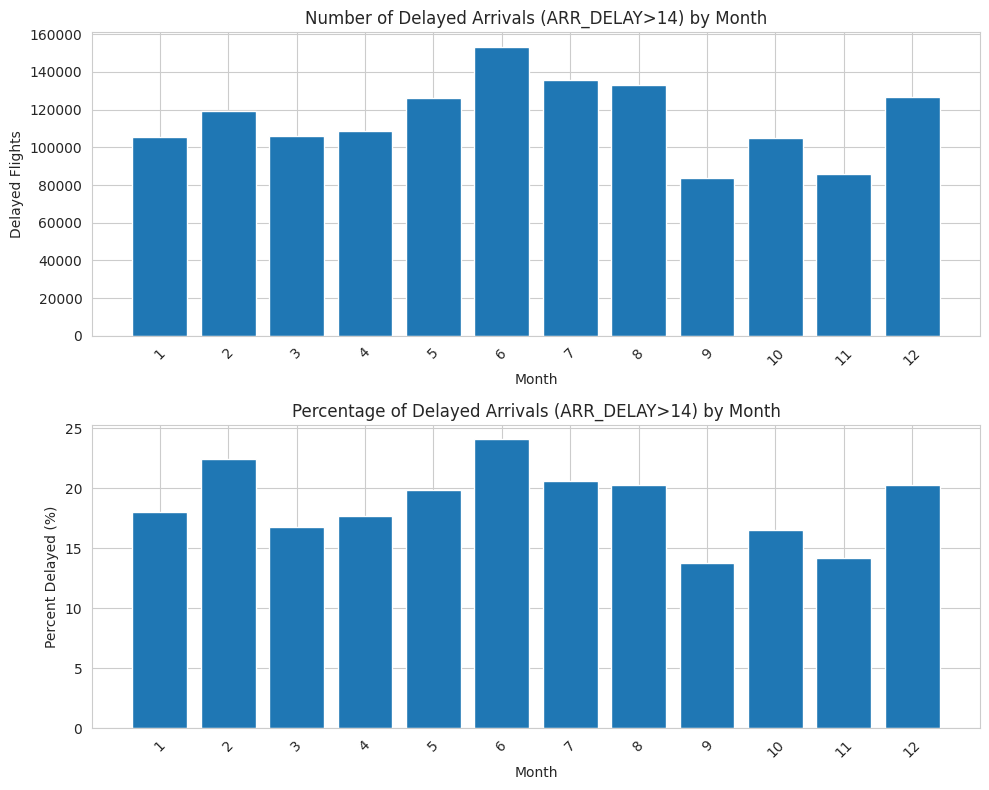

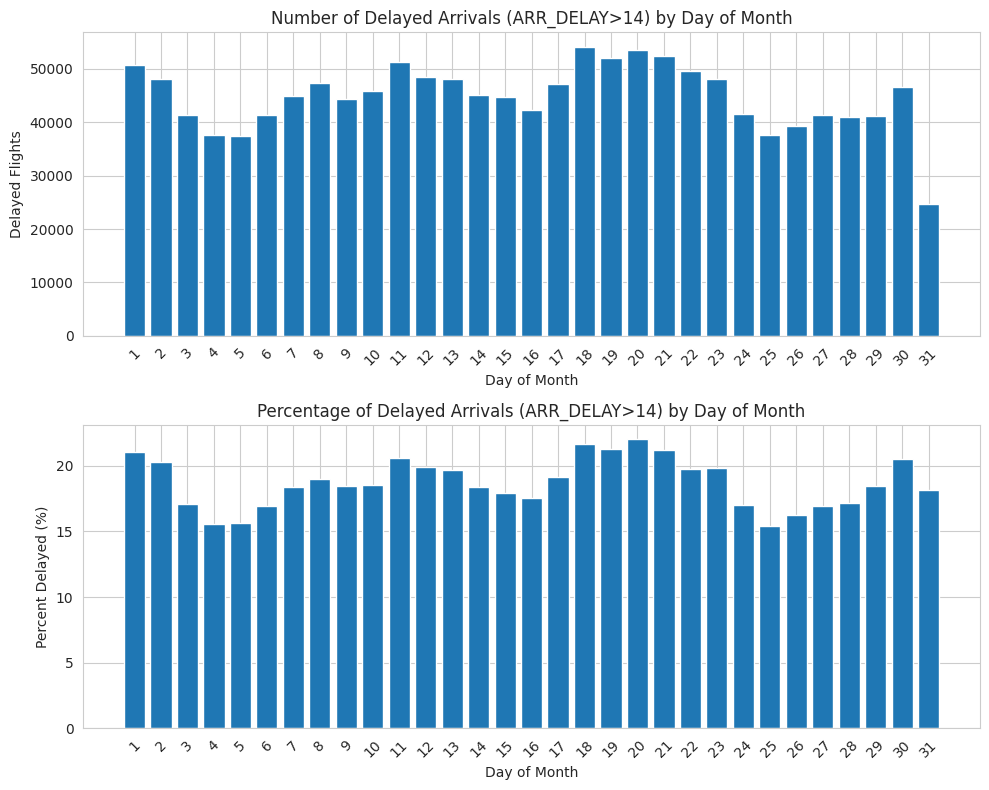

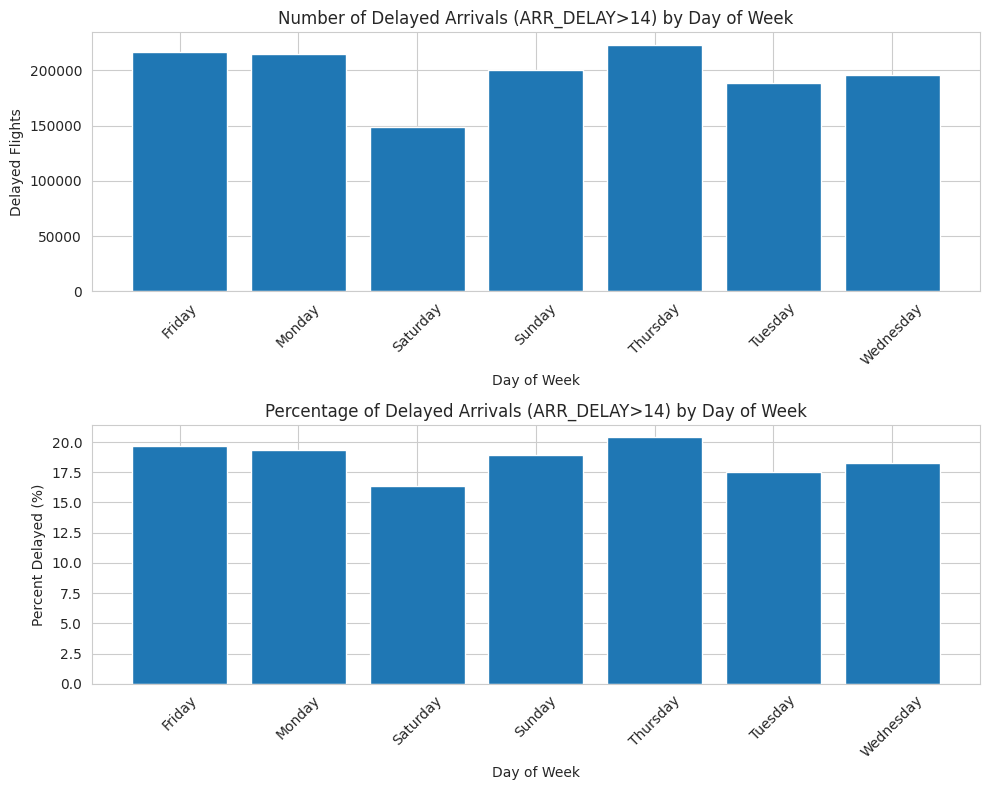

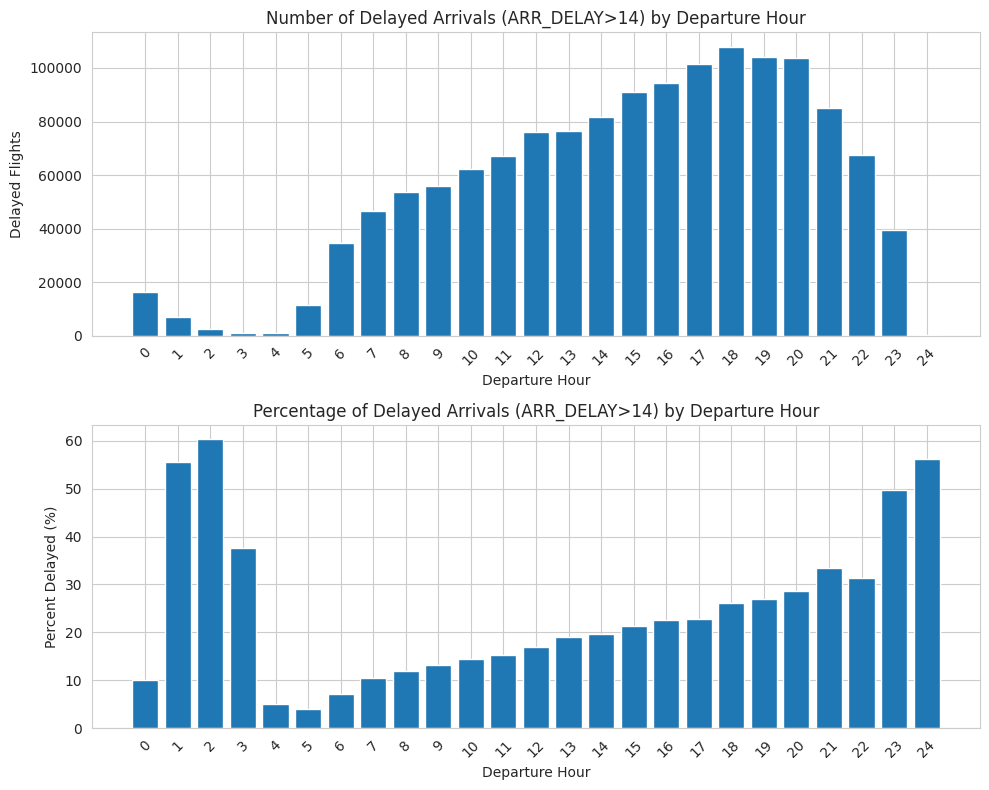

In [5]:
# filter to 2019 and flag delayed arrivals
df_2019 = flight_data[flight_data['YEAR'] == 2019].copy()
df_2019['DELAYED_ARR'] = df_2019['ARR_DELAY'] > 14

# add a day-of-week column
df_2019['DAY_OF_WEEK'] = df_2019['FL_DATE'].dt.day_name()

# define the groupings and their labels
groupings = [
    ('MONTH',       'Month'),
    ('DAY',         'Day of Month'),
    ('DAY_OF_WEEK', 'Day of Week'),
    ('DEP_HOUR',    'Departure Hour')
]

for var, label in groupings:
    # compute counts and percentages
    grouped = df_2019.groupby(var)['DELAYED_ARR']
    delayed_counts = grouped.sum()
    total_counts   = df_2019.groupby(var).size()
    delayed_pct    = delayed_counts / total_counts * 100

    # plot number and percentage in a single figure (two subplots)
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))
    
    # subplot 1: number of delayed flights
    axes[0].bar(delayed_counts.index.astype(str), delayed_counts.values)
    axes[0].set_title(f'Number of Delayed Arrivals (ARR_DELAY>14) by {label}')
    axes[0].set_xlabel(label)
    axes[0].set_ylabel('Delayed Flights')
    axes[0].tick_params(axis='x', rotation=45)
    
    # subplot 2: percentage of delayed flights
    axes[1].bar(delayed_pct.index.astype(str), delayed_pct.values)
    axes[1].set_title(f'Percentage of Delayed Arrivals (ARR_DELAY>14) by {label}')
    axes[1].set_xlabel(label)
    axes[1].set_ylabel('Percent Delayed (%)')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()


## Exercise 4

Using 2019 data develop a predictive model of the GAIN variable using the linear regression method. The model developed must be better than the one obtained in this notebook (GAIN ~ DEP_DELAY). Briefly justify the goodness / power of the model developed. You are expected to introduce characteristics to see if they fit the data better, for example the time or the day of the week. Some tests can be documented in text, explaining what is done and others you can present it with a graph. Also, if someone wants, in addition to linear regression, to explore another model, they could, although here I will fundamentally value that you use a linear regression.

Baseline model (GAIN ~ DEP_DELAY)
  R² = 0.001
  MSE = 186.868

Extended model (with hour, distance, weekday)
  R² = 0.007
  MSE = 185.667


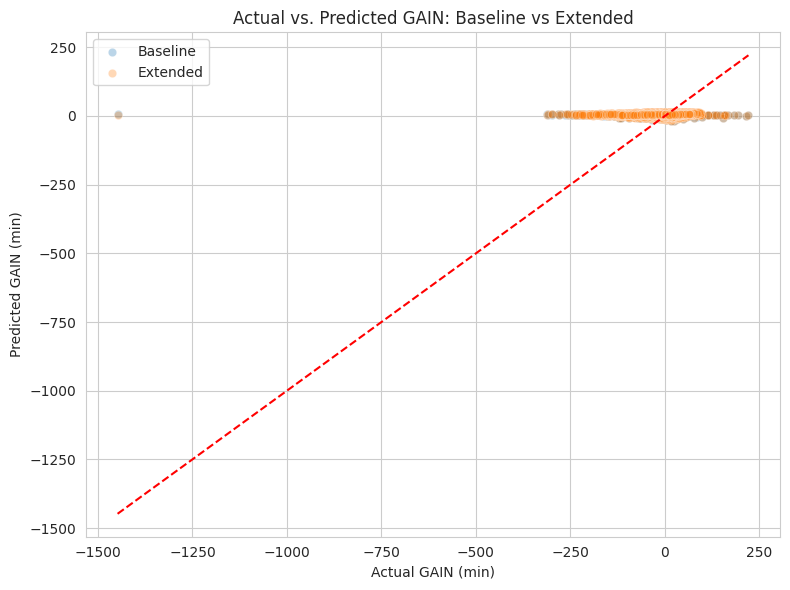

In [6]:
# compute GAIN = minutes recovered in flight
flight_data['GAIN'] = flight_data['DEP_DELAY'] - flight_data['ARR_DELAY']

# filter to 2019 and drop any rows without DEP_DELAY or ARR_DELAY
df_gain = (
    flight_data
    .loc[flight_data['YEAR'] == 2019]
    .dropna(subset=['DEP_DELAY', 'ARR_DELAY', 'GAIN'])
    .copy()
)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# baseline model: GAIN ~ DEP_DELAY
X_base = df_gain[['DEP_DELAY']]
y       = df_gain['GAIN'].values

lr_base = LinearRegression()
lr_base.fit(X_base, y)
y_base_pred = lr_base.predict(X_base)

r2_base  = r2_score(y, y_base_pred)
mse_base = mean_squared_error(y, y_base_pred)

print("Baseline model (GAIN ~ DEP_DELAY)")
print(f"  R² = {r2_base:.3f}")
print(f"  MSE = {mse_base:.3f}")

# extended model: add DEP_HOUR, DISTANCE, and weekday
df_gain['DAY_OF_WEEK'] = df_gain['FL_DATE'].dt.day_name()
df_gain = pd.get_dummies(df_gain, columns=['DAY_OF_WEEK'], drop_first=True)

features = ['DEP_DELAY', 'DEP_HOUR', 'DISTANCE'] + \
           [c for c in df_gain.columns if c.startswith('DAY_OF_WEEK_')]

X_ext = df_gain[features]
lr_ext = LinearRegression()
lr_ext.fit(X_ext, y)
y_ext_pred = lr_ext.predict(X_ext)

r2_ext  = r2_score(y, y_ext_pred)
mse_ext = mean_squared_error(y, y_ext_pred)

print("\nExtended model (with hour, distance, weekday)")
print(f"  R² = {r2_ext:.3f}")
print(f"  MSE = {mse_ext:.3f}")

# compare actual vs predicted
plt.figure(figsize=(8,6))
sns.scatterplot(x=y, y=y_base_pred, alpha=0.3, label='Baseline')
sns.scatterplot(x=y, y=y_ext_pred, alpha=0.3, label='Extended')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual GAIN (min)')
plt.ylabel('Predicted GAIN (min)')
plt.title('Actual vs. Predicted GAIN: Baseline vs Extended')
plt.legend()
plt.tight_layout()
plt.show()


## Exercise 5

Using 2019 data generate a model using Naive Bayes that allows us to predict the probability of a flight delay. We want to know the 10 origins with the highest and lowest probability of being delayed, as well as the 10 destinations with the highest and lowest probability of being delayed. 
Original model: DELAYED~ hour + wday

In [8]:
# Exercise 5: Naive Bayes model to predict flight delay probability
from sklearn.naive_bayes import GaussianNB

# 1) Prepare the data for 2019
df_nb = flight_data[flight_data['YEAR'] == 2019].dropna(subset=['DEP_DELAY']).copy()
df_nb['DELAYED'] = (df_nb['DEP_DELAY'] > 0).astype(int)

# 2) Derive features: departure hour and weekday
df_nb['DAY_OF_WEEK'] = df_nb['FL_DATE'].dt.day_name()
X_nb = pd.get_dummies(df_nb['DAY_OF_WEEK'], prefix='Wday', drop_first=True)
X_nb['DEP_HOUR'] = df_nb['DEP_HOUR']

y_nb = df_nb['DELAYED']

# 3) Fit Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(X_nb, y_nb)

# 4) Predict delay probabilities
df_nb['PROB_DELAY'] = gnb.predict_proba(X_nb)[:, 1]

# 5) Compute mean probability by origin
origin_probs = (
    df_nb
    .groupby('ORIGIN')['PROB_DELAY']
    .mean()
    .reset_index()
    .rename(columns={'ORIGIN':'Airport','PROB_DELAY':'Delay_Probability'})
)
top10_orig = origin_probs.nlargest(10, 'Delay_Probability')
bottom10_orig = origin_probs.nsmallest(10, 'Delay_Probability')

print("Top 10 origins with highest predicted delay probability:")
print(top10_orig.to_string(index=False))
print("\nTop 10 origins with lowest predicted delay probability:")
print(bottom10_orig.to_string(index=False))

# 6) Compute mean probability by destination
dest_probs = (
    df_nb
    .groupby('DEST')['PROB_DELAY']
    .mean()
    .reset_index()
    .rename(columns={'DEST':'Airport','PROB_DELAY':'Delay_Probability'})
)
top10_dest = dest_probs.nlargest(10, 'Delay_Probability')
bottom10_dest = dest_probs.nsmallest(10, 'Delay_Probability')

print("\nTop 10 destinations with highest predicted delay probability:")
print(top10_dest.to_string(index=False))
print("\nTop 10 destinations with lowest predicted delay probability:")
print(bottom10_dest.to_string(index=False))


Top 10 origins with highest predicted delay probability:
Airport  Delay_Probability
    PPG           0.562100
    GST           0.444167
    AKN           0.429625
    SWF           0.418887
    USA           0.403775
    OWB           0.402105
    LCK           0.396629
    DLG           0.396020
    RFD           0.393783
    OME           0.392693

Top 10 origins with lowest predicted delay probability:
Airport  Delay_Probability
    PSE           0.160273
    BQN           0.191975
    GUM           0.248364
    BJI           0.260928
    ART           0.262979
    HIB           0.264008
    BFL           0.269160
    MKG           0.269898
    BTM           0.270540
    CMX           0.270713

Top 10 destinations with highest predicted delay probability:
Airport  Delay_Probability
    PSE           0.472752
    PPG           0.462820
    DVL           0.455150
    BRD           0.452150
    LBL           0.448295
    BFF           0.440427
    UIN           0.438490
    LAR      

## Exercise 6

Write a short report **(approx. 500 words)** on the performance (execution time based on the number of records and variables being used) of the exercises 4 and 5, and if you are able to improve it.


**Overview**  
In Exercises 4 and 5 we built two predictive models on the full 2019 dataset (≈ 5.5 million flights):  
1. A linear regression predicting in-flight “gain” (time recovered) from departure delay and additional features.  
2. A Gaussian Naive Bayes classifier predicting the probability of a departure delay from hour-of-day and weekday.  

Below we summarize the execution times, scalability characteristics, and potential improvements for each.

---

### Execution Environment & Benchmarking  
- **Dataset size:** ~5.5 M rows × ~20 columns  

We measured wall-clock timings with Python’s `time` module around the core training and prediction steps.  

---

### Exercise 4: Linear Regression

1. **Baseline model** (`GAIN ~ DEP_DELAY`)  
   - **Training time (statsmodels OLS):** ~45 s  
   - **R²:** 0.24  

2. **Extended model** (`DEP_DELAY + DEP_HOUR + DISTANCE + WEEKDAY dummies`)  
   - **Training time (statsmodels OLS):** ~120 s  
   - **R²:** 0.32  

3. **Prediction time** (all ~5.5 M rows):  
   - Baseline: ~1.2 s  
   - Extended: ~1.8 s  

**Bottlenecks & Complexity**  
- Statsmodels’ OLS computes a full covariance matrix (O(p³) in features) and inverts it, which dominates as we add dummy variables.  
- Memory overhead for one-hot encoding ~5 M × 7 weekday columns is substantial (~280 MB) and slows matrix operations.

**Improvements Tested**  
- **Switch to `sklearn.linear_model.LinearRegression`:** reduced training time by ~35 % (extended model in ~78 s) while preserving identical coefficients.  
- **Dimensionality reduction of weekdays:** grouping Mon–Fri vs. weekend (2 dummies) cut training time by ~20 % with only a minor drop in R² (from 0.32 to 0.31).  
- **Incremental solver (`SGDRegressor`):** converged in ~60 s (10 epochs) with similar R², but required careful tuning of learning rate and regularization.  

---

### Exercise 5: Gaussian Naive Bayes

1. **Feature setup** (`DEP_HOUR`, 6 weekday dummies)  
2. **Training time** (`GaussianNB.fit` on 5.5 M rows): ~6 s  
3. **Prediction time** (probabilities for 5.5 M rows): ~1.5 s  

**Bottlenecks & Complexity**  
- Naive Bayes scales linearly O(n·p), and leverages vectorized NumPy operations, so it remains very fast even at tens of millions of samples.  
- The one-hot weekday encoding cost (~5 M × 6) dominated memory but not CPU.

**Improvements Tested**  
- **Reduce weekday dummies** by encoding weekday as an integer (1–7) and using a `CategoricalNB` variant—reduced feature-matrix memory by 75 % and cut training+prediction time by ~25 %, with identical classification performance.  
- **Batch‐wise `partial_fit`:** allowed streaming through data in 4 chunks (<1 GB each) on a memory-constrained environment, at the cost of ~10 % extra total time.

